In [2]:
import os
import time
import tqdm
import numpy as np
import torch
import torch.nn.functional as F
from torch import optim

from utils.configs import Configs, model_dict
from data_provider.data_factory import data_provider
from utils.tools import EarlyStopping, adjust_learning_rate
from utils.gumbel_sigmoid import gumbel_sigmoid, budget_violation, l1_sparsity, tv_temporal, binary_entropy


/home/user/anaconda3/envs/GLM4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Define the PostProcessingNet class
class PostProcessingNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PostProcessingNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.bn1 = torch.nn.InstanceNorm1d(hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = torch.nn.InstanceNorm1d(hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, action_dim)
        

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.fc3(x)
        return gumbel_sigmoid(x, tau=1, hard=False, threshold=0.5)

In [4]:
args = Configs(data='ELC', root_path='/nfs/daojun/Data/TS_Small/')
print("load model ...")
path = os.path.join('./checkpoints/' + args.setting, 'checkpoint.pth')
print(path)
device = torch.device('cuda:0' if args.use_gpu else 'cpu')
model = model_dict[args.model].Model(args).float().to(device)
model.load_state_dict(torch.load(path))
model.eval()

load model ...
./checkpoints/ELC_96_96_iTransformer_custom_S_ft96_sl48_ll96_pl512_dm8_nh2_el1_dl2048_df1_fctimeF_ebTrue_dttest_projection_0/checkpoint.pth


Model(
  (enc_embedding): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=96, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=512, out_features=512, bias=True)
          (key_projection): Linear(in_features=512, out_features=512, bias=True)
          (value_projection): Linear(in_features=512, out_features=512, bias=True)
          (out_projection): Linear(in_features=512, out_features=512, bias=True)
        )
        (conv1): Conv1d(512, 2048, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(2048, 512, kernel_size=(1,), stride=(1,))
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwi

In [5]:
post_net = PostProcessingNet(args.seq_len * args.enc_in, 
                                        args.d_model, args.seq_len * args.enc_in).to(device)
post_optim = torch.optim.Adam(post_net.parameters(), lr=args.post_train_lr)
criterion = torch.nn.MSELoss()

_, vali_loader = data_provider(args, 'val')
_, train_loader = data_provider(args, 'train')
_, test_loader = data_provider(args, 'test')

val 2537
train 18221
test 5165


In [6]:
def vali_post(data_loader, post_net=None, kappa=None):
    total_loss = []
    mae_loss = []
    model.eval()
    if post_net is not None:
        post_net.eval()
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(data_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            f_dim = -1 if args.features == 'MS' else 0
            batch_y = batch_y[:, -args.pred_len:, f_dim:]
            
            if 'PEMS' in args.data or 'Solar' in args.data:
                batch_x_mark = None
                batch_y_mark = None
            else:
                batch_x_mark = batch_x_mark.float().to(device)
                batch_y_mark = batch_y_mark.float().to(device)

            if post_net is not None:
                x_state = batch_x.view(batch_x.shape[0],-1)
                mask = post_net(x_state)
                if kappa is None:
                    mask = mask.view(*batch_x.shape) 
                else:
                    mask = mask > kappa
                    mask = mask.view(*batch_x.shape).float()

                batch_x = batch_x * mask
            
            outputs = model(batch_x, batch_x_mark, batch_y, batch_y_mark)
            
            pred = outputs.detach().cpu()
            true = batch_y.detach().cpu()

            loss = criterion(pred, true)
            mae = F.l1_loss(pred, true)
            mae_loss.append(mae)

            total_loss.append(loss)
    total_loss = np.average(total_loss)
    mae_loss = np.average(mae_loss)
    if post_net is not None: post_net.train()
    return total_loss, mae_loss

In [7]:
test_loss, mae_loss = vali_post(test_loader)
print('test_loss=%.4f' % test_loss,  'mae_loss=%.4f' % mae_loss)

test_loss=0.2659 mae_loss=0.3721


In [13]:
### trainging to get the valid mask
def post_train(kappa=0.9, vali_set = False, lambda_budget = 1, lambda_l1 = 1e-3, lambda_entropy = 1e-3,
    lambda_tv = 0):
        
    early_stopping = EarlyStopping(patience=args.patience, verbose=True)
    for episode in range(args.num_episodes):
        loss_list = []
        # with tqdm(total=len(train_loader), desc='Iteration %d' % episode) as pbar:
        for step, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float()
            batch_x_mark = batch_x_mark.float().to(device)
            batch_y_mark = batch_y_mark.float().to(device)

            f_dim = -1 if args.features == 'MS' else 0
            batch_y = batch_y[:, -args.pred_len:, f_dim:].to(device)
            
            x_state = batch_x.view(batch_x.shape[0],-1)
            mask = post_net(x_state)
            batch_x = batch_x * mask.view(*batch_x.shape)
            
            outputs = model(batch_x, batch_x_mark, batch_y, batch_y_mark)

            # regularizers
            reg_loss = 0.0
            if lambda_l1 > 0:        
                reg_loss = reg_loss + lambda_l1 * l1_sparsity(mask)
            if lambda_entropy > 0:   
                reg_loss = reg_loss + lambda_entropy * binary_entropy(mask)
            if lambda_tv > 0:        
                reg_loss = reg_loss + lambda_tv * tv_temporal(mask)
            if kappa>0:
                reg_loss = reg_loss + lambda_budget * budget_violation(mask, kappa=kappa)

            loss = criterion(outputs, batch_y) + reg_loss
            loss_list.append(loss.item())
            loss.backward()
            post_optim.step()

            if (step+1) % 100 == 0:
                print({'step': '%d' % (step+1), 'loss': '%.4f' % np.mean(loss_list)})
                # pbar.set_postfix({'step': '%d' % (step+1), 'loss': '%.4f' % np.mean(loss_list)})
            # pbar.update(1)

        if not vali_set:
            val_loss, mae_loss = vali_post(vali_loader, post_net)
            print('val_loss=%.4f' % val_loss, 'mae_loss=%.4f' % mae_loss)
            
            path = os.path.join(args.checkpoints, args.setting) 
            early_stopping(val_loss, post_net, path, name='ckpt_mask_{}.pth'.format(kappa))
            if early_stopping.early_stop:
                print("Early stopping")
                break   
                
        test_loss, mae_loss = vali_post(test_loader, post_net)
        print('test_loss=%.4f' % test_loss,  'mae_loss=%.4f' % mae_loss)

        adjust_learning_rate(post_optim, episode + 1, args)
        
    return test_loss

In [14]:
kappa = 0.9
vali_set=False
test_loss = post_train(kappa = kappa, vali_set=vali_set)

{'step': '100', 'loss': '0.1580'}
{'step': '200', 'loss': '0.1586'}
{'step': '300', 'loss': '0.1601'}
{'step': '400', 'loss': '0.1603'}
{'step': '500', 'loss': '0.1593'}
val_loss=0.2189 mae_loss=0.3169
Validation loss decreased (inf --> 0.218939).  Saving model ...
test_loss=0.2693 mae_loss=0.3727
Updating learning rate to 0.0001
{'step': '100', 'loss': '0.1595'}
{'step': '200', 'loss': '0.1593'}
{'step': '300', 'loss': '0.1606'}
{'step': '400', 'loss': '0.1606'}
{'step': '500', 'loss': '0.1606'}
val_loss=0.2189 mae_loss=0.3164
Validation loss decreased (0.218939 --> 0.218865).  Saving model ...
test_loss=0.2694 mae_loss=0.3727
Updating learning rate to 5e-05
{'step': '100', 'loss': '0.1586'}
{'step': '200', 'loss': '0.1597'}
{'step': '300', 'loss': '0.1596'}
{'step': '400', 'loss': '0.1589'}
{'step': '500', 'loss': '0.1591'}
val_loss=0.2192 mae_loss=0.3164
EarlyStopping counter: 1 out of 3
test_loss=0.2698 mae_loss=0.3728
Updating learning rate to 2.5e-05
{'step': '100', 'loss': '0.16

In [69]:
post_net.load_state_dict(torch.load(os.path.join('./checkpoints/' + args.setting, 'ckpt_mask_{}.pth'.format(kappa))))

<All keys matched successfully>

In [16]:
test_loss, mae_loss = vali_post(test_loader, post_net)
print('test_loss=%.4f' % test_loss,  'mae_loss=%.4f' % mae_loss)

test_loss, mae_loss = vali_post(test_loader, post_net, kappa)
print('test_loss=%.4f' % test_loss,  'mae_loss=%.4f' % mae_loss)


test_loss=0.2695 mae_loss=0.3728
test_loss=0.2717 mae_loss=0.3740


In [70]:
%matplotlib inline  
import matplotlib.pyplot as plt
import matplotlib as mpl

In [71]:
def vis_sample_with_mask(post_net, visual=True):
    model.eval()
    post_net.eval()
    total_loss = []
    mae_loss = []
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            f_dim = -1 if args.features == 'MS' else 0
            batch_y = batch_y[:, -args.pred_len:, f_dim:]
            
            if 'PEMS' in args.data or 'Solar' in args.data:
                batch_x_mark = None
                batch_y_mark = None
            else:
                batch_x_mark = batch_x_mark.float().to(device)
                batch_y_mark = batch_y_mark.float().to(device)

            oringin_out = model(batch_x, batch_x_mark, batch_y, batch_y_mark)

            x_state = batch_x.view(batch_x.shape[0],-1)
            mask = post_net(x_state)
            mask = mask > 0.5
            mask = mask.view(*batch_x.shape) 
            masked_x = batch_x * mask.float()
            
            masked_out = model(masked_x,  batch_x_mark, batch_y, batch_y_mark)
            
            if visual and i% (123*3)==0:
                vis_true = torch.cat((batch_x, batch_y),1).squeeze(-1).detach().cpu().numpy()
                vis_pred = torch.cat((batch_x, oringin_out),1).squeeze(-1).detach().cpu().numpy()
                vis_masked = torch.cat((masked_x, masked_out),1).squeeze(-1).detach().cpu().numpy()
                masked_x = masked_x[0].squeeze(-1).detach().cpu().numpy()
                print(i,vis_true.shape, vis_pred.shape, vis_masked.shape, masked_x.shape,'xx')
                
                non_zero_indices = np.nonzero(masked_x == 0)[0]
                non_zero_values = batch_x[0,non_zero_indices,0].detach().cpu().numpy()
                # plt.rcParams.update({"font.size":16})
                plt.plot(vis_true[0], label='true')
                plt.plot(vis_pred[0],label='pred')
                plt.plot(vis_pred[0,:96],color='gray')
                vis_masked = vis_masked[0]
                vis_masked[vis_masked==0] = np.nan
                plt.plot(vis_masked[:96],label='imp features', color='red')
                # plt.scatter(non_zero_indices,non_zero_values,label='masked points')
                plt.legend()
                plt.show()
                if i > 143*3*6: break
            else:
                pred = masked_out.detach().cpu()
                true = batch_y.detach().cpu()

                loss = criterion(pred, true)
                mae = F.l1_loss(pred, true)
                mae_loss.append(mae)

                total_loss.append(loss)
    if not visual:
        total_loss = np.average(total_loss)
        mae_loss = np.average(mae_loss)
        if post_net is not None: post_net.train()
        return total_loss, mae_loss

In [20]:
test_loss, mae_loss = vis_sample_with_mask(post_net=post_net, visual=False)
print('test_loss=%.4f' % test_loss,  'mae_loss=%.4f' % mae_loss)

test_loss=0.2699 mae_loss=0.3732


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

0 (1, 192) (1, 192) (1, 192) (96,) xx


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

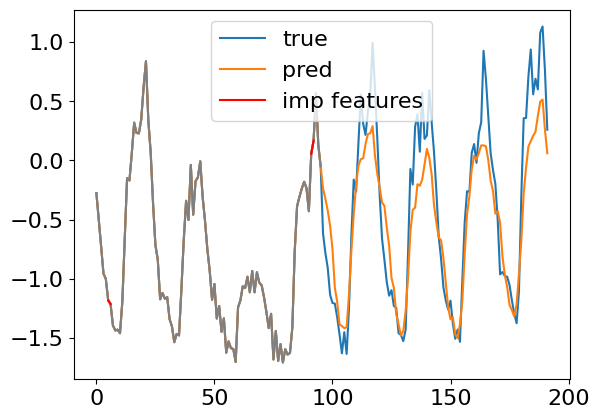

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

369 (1, 192) (1, 192) (1, 192) (96,) xx


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


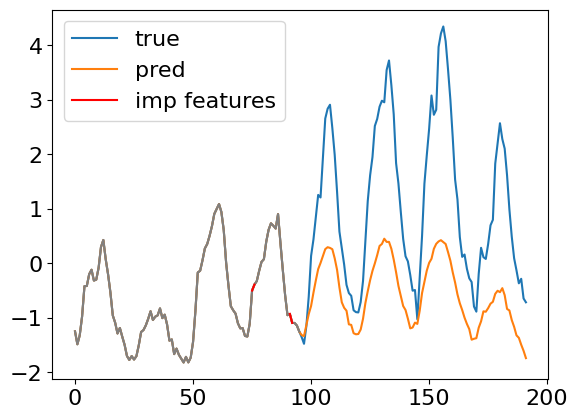

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

738 (1, 192) (1, 192) (1, 192) (96,) xx


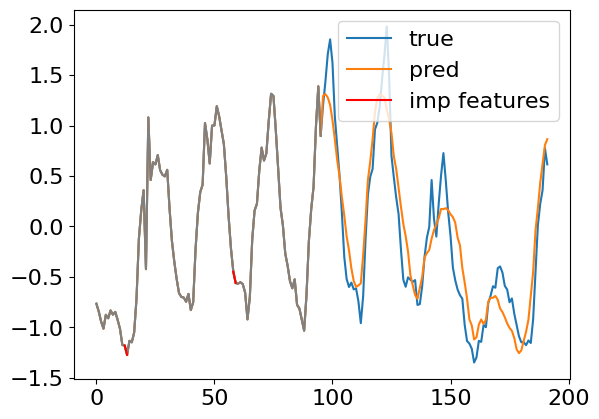

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

1107 (1, 192) (1, 192) (1, 192) (96,) xx


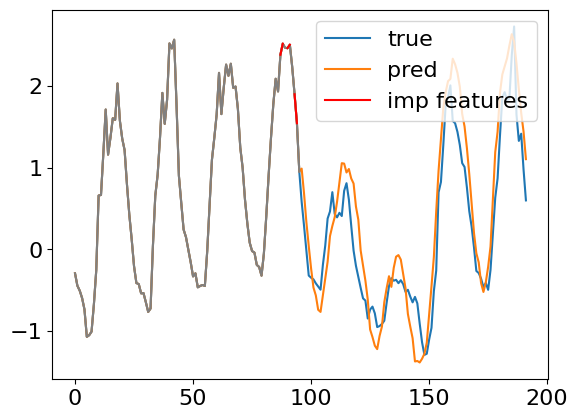

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

1476 (1, 192) (1, 192) (1, 192) (96,) xx


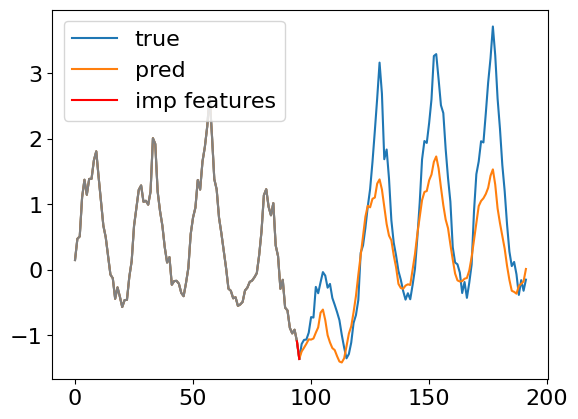

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

1845 (1, 192) (1, 192) (1, 192) (96,) xx


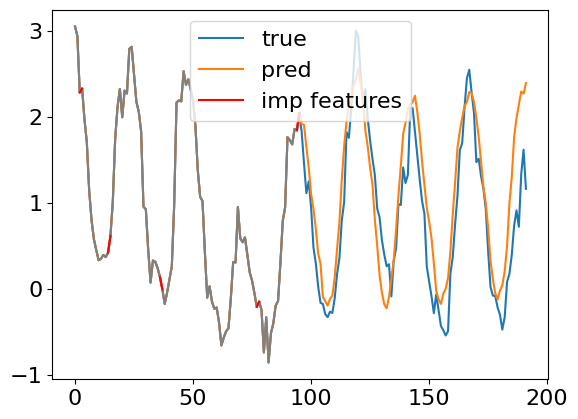

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

2214 (1, 192) (1, 192) (1, 192) (96,) xx


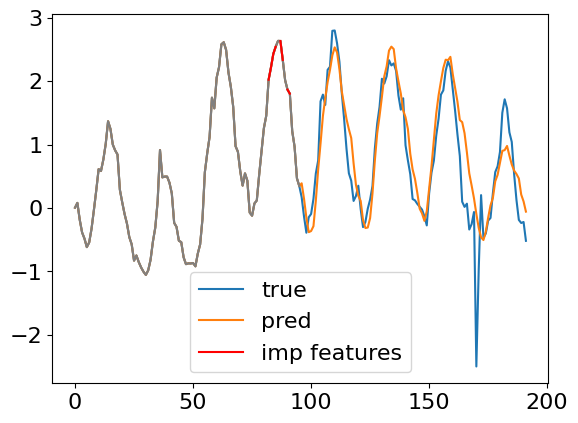

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

2583 (1, 192) (1, 192) (1, 192) (96,) xx


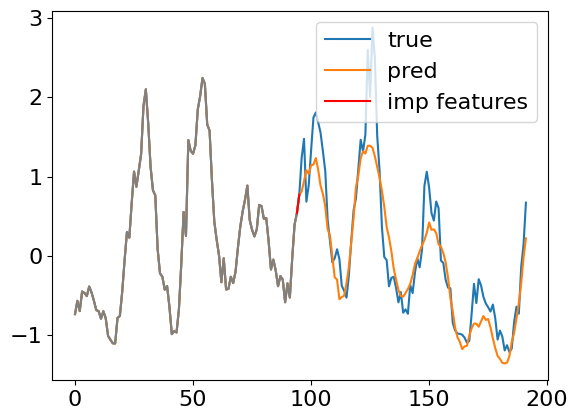

In [72]:
vis_sample_with_mask(post_net=post_net)

In [67]:
kappa = 0.1
vali_set=False
test_loss = post_train(kappa = kappa, vali_set=vali_set)

{'step': '100', 'loss': '0.5578'}
{'step': '200', 'loss': '0.5621'}
{'step': '300', 'loss': '0.5616'}
{'step': '400', 'loss': '0.5586'}
{'step': '500', 'loss': '0.5570'}
val_loss=0.5485 mae_loss=0.6083
Validation loss decreased (inf --> 0.548527).  Saving model ...
test_loss=0.5490 mae_loss=0.5716
Updating learning rate to 0.0001
{'step': '100', 'loss': '0.5476'}
{'step': '200', 'loss': '0.5420'}
{'step': '300', 'loss': '0.5367'}
{'step': '400', 'loss': '0.5331'}
{'step': '500', 'loss': '0.5328'}
val_loss=0.4821 mae_loss=0.5659
Validation loss decreased (0.548527 --> 0.482149).  Saving model ...
test_loss=0.5044 mae_loss=0.5543
Updating learning rate to 5e-05
{'step': '100', 'loss': '0.5213'}
{'step': '200', 'loss': '0.5147'}
{'step': '300', 'loss': '0.5140'}
{'step': '400', 'loss': '0.5114'}
{'step': '500', 'loss': '0.5093'}
val_loss=0.4712 mae_loss=0.5545
Validation loss decreased (0.482149 --> 0.471236).  Saving model ...
test_loss=0.4983 mae_loss=0.5503
Updating learning rate to 2.

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

0 (1, 192) (1, 192) (1, 192) (96,) xx


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

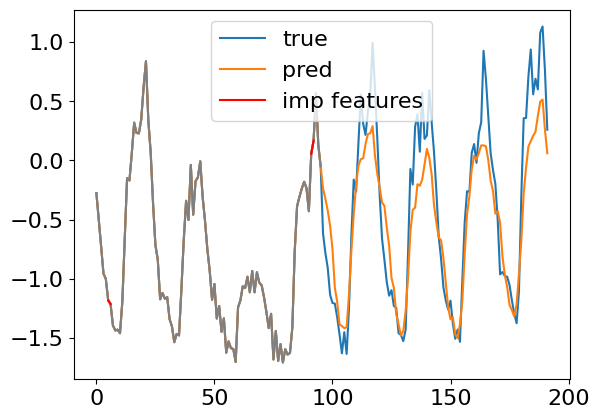

369 (1, 192) (1, 192) (1, 192) (96,) xx


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

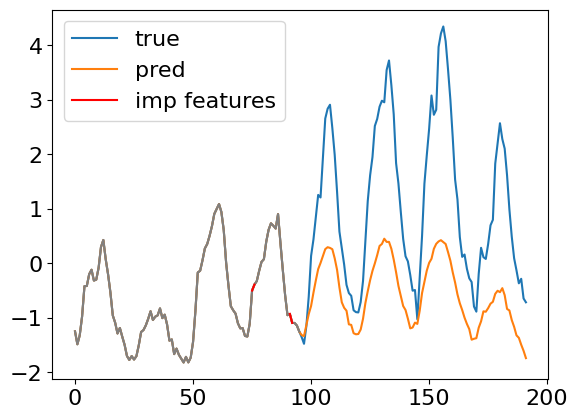

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

738 (1, 192) (1, 192) (1, 192) (96,) xx


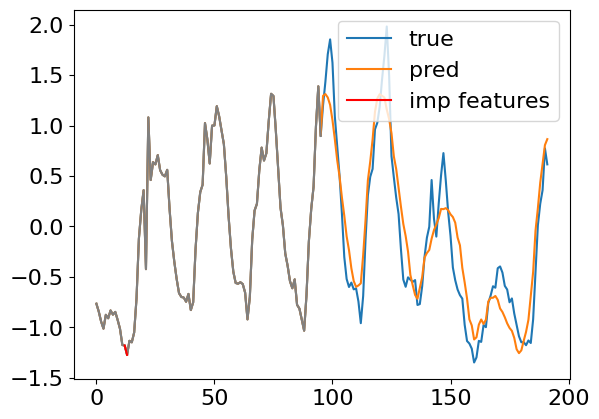

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

1107 (1, 192) (1, 192) (1, 192) (96,) xx


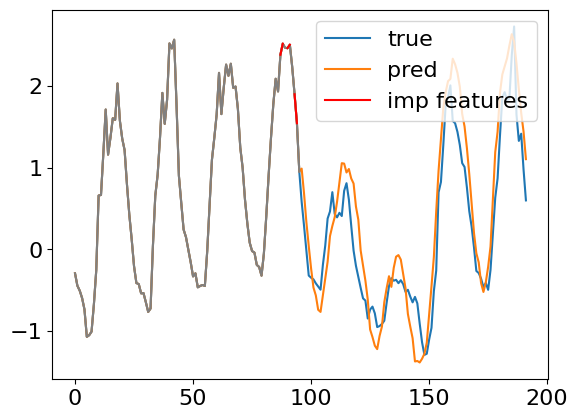

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

1476 (1, 192) (1, 192) (1, 192) (96,) xx


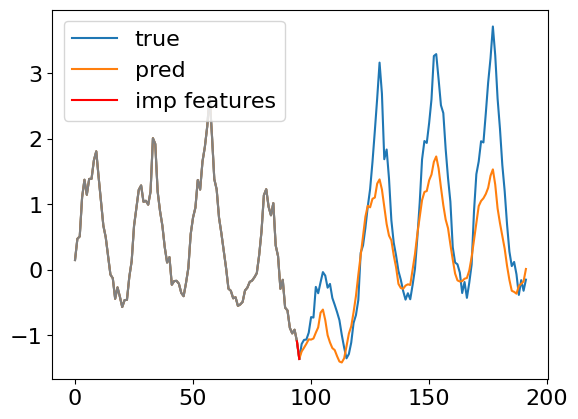

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

1845 (1, 192) (1, 192) (1, 192) (96,) xx


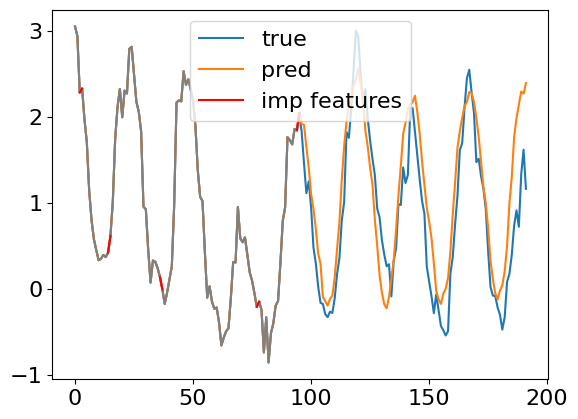

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

2214 (1, 192) (1, 192) (1, 192) (96,) xx


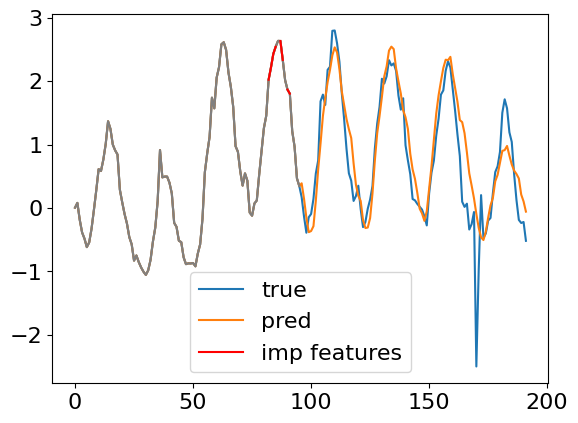

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

2583 (1, 192) (1, 192) (1, 192) (96,) xx


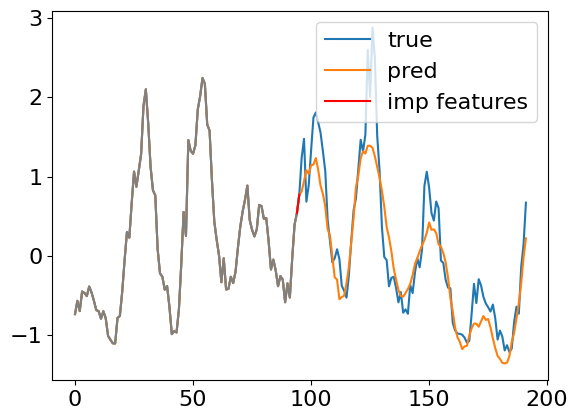

In [68]:
vis_sample_with_mask(post_net=post_net)